# RNN and Keras

In [3]:
# You can safely ignore any warnings on importing this
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Keras introduction

In [19]:
x = np.linspace(0,50,100)

np.random.seed(123)
noise = np.random.normal(loc = 0.0, scale = 4.0, size = len(x))

In [20]:
y = 2 * x + 3 + noise

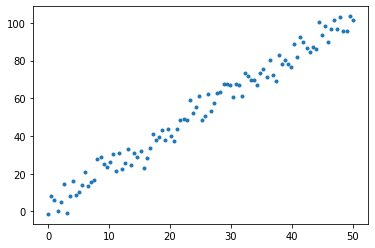

In [21]:
plt.plot(x, y, '.')

## Neural Network with Keras

### Load Keras model

In [22]:
from keras.models import Sequential
from keras.layers import Dense

### Create sequential model with Keras

In [23]:
model = Sequential()
# 4 Neurons, expecting only 1 feature with input_dim=1
model.add(Dense(4, input_dim=1, activation='relu'))
# 4 Neurons (Play around with this number!)
model.add(Dense(4, activation='relu'))
# One final output of y, so only 1 neuron
model.add(Dense(1, activation='linear'))
# Compil the layers
model.compile(loss='mse', optimizer='adam')

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4)                 8         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
Total params: 33
Trainable params: 33
Non-trainable params: 0
_________________________________________________________________


### Train model

In [25]:
model.fit(x, y, epochs=500, verbose=1)


======] - 0s 2ms/step - loss: 22.1119
Epoch 257/500
4/4 [==============================] - 0s 1ms/step - loss: 19.8508
Epoch 258/500
4/4 [==============================] - 0s 1ms/step - loss: 18.2155
Epoch 259/500
4/4 [==============================] - 0s 2ms/step - loss: 20.2823
Epoch 260/500
4/4 [==============================] - 0s 1ms/step - loss: 18.3181
Epoch 261/500
4/4 [==============================] - 0s 2ms/step - loss: 23.8892
Epoch 262/500
4/4 [==============================] - 0s 2ms/step - loss: 19.8343
Epoch 263/500
4/4 [==============================] - 0s 1ms/step - loss: 21.4941
Epoch 264/500
4/4 [==============================] - 0s 2ms/step - loss: 21.7271
Epoch 265/500
4/4 [==============================] - 0s 2ms/step - loss: 24.1176
Epoch 266/500
4/4 [==============================] - 0s 2ms/step - loss: 21.6373
Epoch 267/500
4/4 [==============================] - 0s 1ms/step - loss: 22.5920
Epoch 268/500
4/4 [==============================] - 0s 1ms/step - loss

### Evaluate Regression Model

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = model.predict(x)

In [30]:
mean_squared_error(y, y_pred)

20.79628018835724

### Predict new x

In [26]:
x_for_predictions = np.linspace(0,50,1000)

In [27]:
y_predicted = model.predict(x_for_predictions)

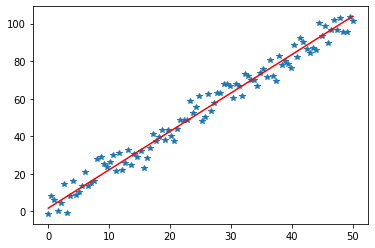

In [28]:
plt.plot(x, y, '*')
plt.plot(x_for_predictions,y_predicted, 'r')

# RNN For sales prediction

In [31]:
df = pd.read_csv('Dataset\Alcohol_Sales.csv', index_col = 'DATE', parse_dates=True)
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [32]:
df.index

DatetimeIndex(['1992-01-01', '1992-02-01', '1992-03-01', '1992-04-01',
               '1992-05-01', '1992-06-01', '1992-07-01', '1992-08-01',
               '1992-09-01', '1992-10-01',
               ...
               '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
               '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
               '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', length=325, freq=None)

In [33]:
df.freq = 'MS'

In [34]:
df.columns = ['Sales']

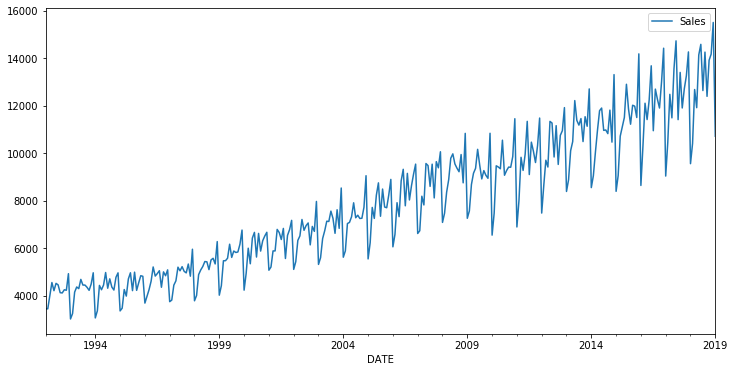

In [35]:
df.plot(figsize=(12,6))

## ETS Decompose

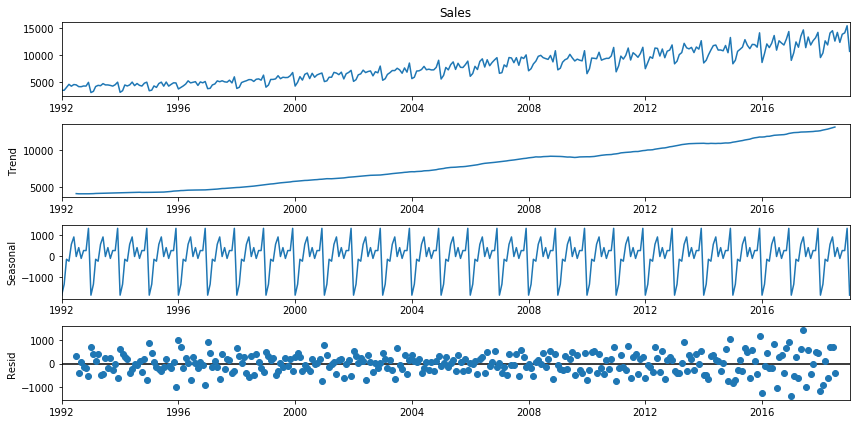

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose
results = seasonal_decompose(df['Sales'])

from pylab import rcParams
rcParams['figure.figsize'] = 12,6
results.plot();

There is confirmed seasonality.
## Train Test split

In [39]:
df.shape

(325, 1)

In [40]:
train = df[:-12]
test = df[-12:]

In [41]:
test.shape

(12, 1)

## Scale data

In [42]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
scaler = MinMaxScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [49]:
train_scaled.shape

(313, 1)

In [50]:
test_scaled.shape

(12, 1)

## Time Series Generator

In [51]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [53]:
# Define generator
n_input = 2
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)

In [55]:
print(len(train_scaled))
print(len(generator)) # inpuut = 2, so first 2 inputs used to calculated 3rd values


313
311


In [58]:
X, y = generator[0]
print(f'Given array: {X.flatten()}')
print(f'To predict: {y}')

Given array: [0.03658432 0.03649885]
To predict: [[0.08299855]]


In [73]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train_scaled, train_scaled, length=n_input, batch_size=1)
X, y = generator[0]
print(f'Given array: {X.flatten()}')
print(f'To predict: {y}')

Given array: [0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
To predict: [[0.]]


## Create Model

In [74]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [75]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [76]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [77]:
history = model.fit_generator(generator, epochs=50)

Epoch 1/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0158
Epoch 2/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0088
Epoch 3/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0085
Epoch 4/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0078
Epoch 5/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0076
Epoch 6/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0072
Epoch 7/50
301/301 [==============================] - 1s 5ms/step - loss: 0.0070
Epoch 8/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0046
Epoch 9/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0037
Epoch 10/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0027
Epoch 11/50
301/301 [==============================] - 2s 6ms/step - loss: 0.0033
Epoch 12/50
301/301 [==============================] - 2s 5ms/step - loss: 0.0022
Epoch 13/50
301/301 [====

In [78]:
model.history.history.keys()

dict_keys(['loss'])

In [79]:
loss_per_epoch = model.history.history['loss']

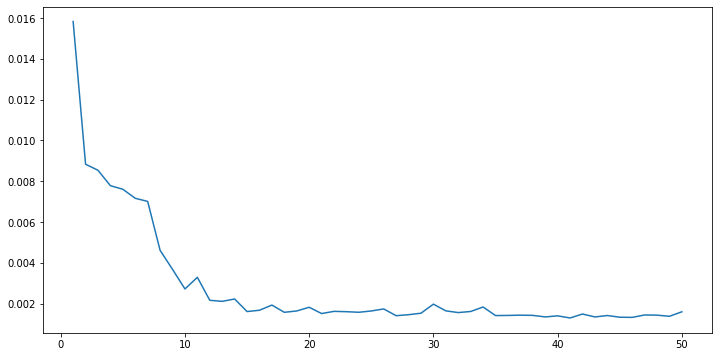

In [80]:
plt.plot(range(1, len(loss_per_epoch)+1), loss_per_epoch)

## Model Evaluation

In [87]:
first_eval_batch = train_scaled[-12:].reshape(1, n_input, n_features)

In [88]:
first_eval_batch

array([[[0.63432772],
        [0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ]]])

In [96]:
pred = model.predict(first_eval_batch)
print(pred.shape)
print(pred)
print(pred[0])
print(pred[0][0])

(1, 1)
[[0.7771652]]
[0.7771652]
0.7771652


In [97]:
test_scaled

array([[0.63116506],
       [0.82502778],
       [0.75972305],
       [0.94939738],
       [0.98743482],
       [0.82135225],
       [0.95956919],
       [0.80049577],
       [0.93025045],
       [0.95247457],
       [1.0661595 ],
       [0.65706471]])

This predicted value will be used as one of 12 inputs for the next prediction.

In [98]:
test_prediction = []

first_eval_batch = train_scaled[-n_input:]
current_batch = first_eval_batch.reshape(1, n_input, n_features)

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]

    test_prediction.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [99]:
test_prediction

[array([0.7771652], dtype=float32),
 array([0.88014656], dtype=float32),
 array([0.8553383], dtype=float32),
 array([1.0146564], dtype=float32),
 array([1.0911882], dtype=float32),
 array([0.83381176], dtype=float32),
 array([0.98907834], dtype=float32),
 array([0.8427553], dtype=float32),
 array([0.935697], dtype=float32),
 array([0.97248954], dtype=float32),
 array([1.0570897], dtype=float32),
 array([0.68488777], dtype=float32)]

## Inverse the test_predictions by un-scale

In [100]:
test_pred_true = scaler.inverse_transform(test_prediction)
test_pred_true

array([[12123.05537629],
       [13327.83464116],
       [13037.60248429],
       [14901.46551049],
       [15796.81066251],
       [12785.76377964],
       [14602.22753376],
       [12890.39446163],
       [13977.71942645],
       [14408.15507942],
       [15397.89224112],
       [11043.50198424]])

In [101]:
test

,Sales
DATE,
2018-02-01,10415
2018-03-01,12683
2018-04-01,11919
2018-05-01,14138
2018-06-01,14583
2018-07-01,12640
2018-08-01,14257
2018-09-01,12396
2018-10-01,13914


In [102]:
test['Predictions'] = test_pred_true
test

,Sales,Predictions
DATE,,
2018-02-01,10415,12123.055376
2018-03-01,12683,13327.834641
2018-04-01,11919,13037.602484
2018-05-01,14138,14901.465510
2018-06-01,14583,15796.810663
2018-07-01,12640,12785.763780
2018-08-01,14257,14602.227534
2018-09-01,12396,12890.394462
2018-10-01,13914,13977.719426


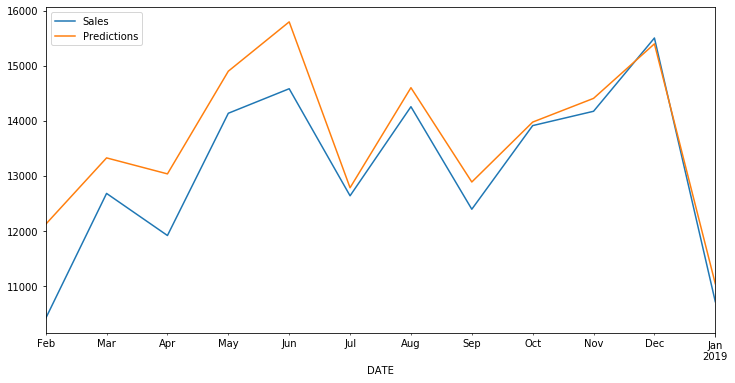

In [103]:
test.plot(figsize=(12,6))

## Save and Reload models

In [104]:
model.save('RNN_sales_Prediction.h5')

In [106]:
# reload a model
from keras.models import load_model
new_model = load_model('RNN_sales_Prediction.h5')
new_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
